# Incorporating covariate information into classifiers

## Creating a covariate dataset that encodes categorical sample variables

The sample data possesses covariates as shown in <a href='https://github.com/cognoma/cancer-data/blob/master/3.explore-mutations.ipynb'>this notebook</a>. These may provide a spurious signal that a classifier accommodates for, and could confound attempts to pick out the actual signal that we desire. This notebook will create a file with encoded information on these covariates. Classifiers being implemented by the machine learning group can use this as additional data to train on.

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

Let's peak at the sample data.

In [2]:
path = os.path.join('data', 'samples.tsv')
covariates_df = pd.read_table(path, index_col=0)
covariates_df.head(10)

,patient_id,sample_type,disease,organ_of_origin,gender,age_diagnosed,dead,days_survived,recurred,days_recurrence_free
sample_id,,,,,,,,,,
TCGA-02-0047-01,TCGA-02-0047,Primary Tumor,glioblastoma multiforme,Brain,Male,78.0,1.0,448.0,NaN,NaN
TCGA-02-0055-01,TCGA-02-0055,Primary Tumor,glioblastoma multiforme,Brain,Female,62.0,1.0,76.0,NaN,NaN
TCGA-02-2483-01,TCGA-02-2483,Primary Tumor,glioblastoma multiforme,Brain,Male,43.0,0.0,466.0,NaN,NaN
TCGA-02-2485-01,TCGA-02-2485,Primary Tumor,glioblastoma multiforme,Brain,Male,53.0,0.0,470.0,NaN,NaN
TCGA-02-2486-01,TCGA-02-2486,Primary Tumor,glioblastoma multiforme,Brain,Male,64.0,0.0,493.0,NaN,NaN
TCGA-04-1348-01,TCGA-04-1348,Primary Tumor,ovarian serous cystadenocarcinoma,Ovary,Female,44.0,1.0,1483.0,NaN,NaN
TCGA-04-1357-01,TCGA-04-1357,Primary Tumor,ovarian serous cystadenocarcinoma,Ovary,Female,52.0,NaN,NaN,NaN,NaN
TCGA-04-1362-01,TCGA-04-1362,Primary Tumor,ovarian serous cystadenocarcinoma,Ovary,Female,59.0,1.0,1348.0,NaN,NaN
TCGA-05-4244-01,TCGA-05-4244,Primary Tumor,lung adenocarcinoma,Lung,Male,70.0,NaN,NaN,NaN,NaN


Let's get a sense of how much missing data there is.

In [3]:
print('Total number of samples: %d' % len(covariates_df))
print('Number of nulls in each column:')
covariates_df.isnull().sum(axis=0)

Total number of samples: 7306
Number of nulls in each column:


patient_id                 0
sample_type                0
disease                    0
organ_of_origin            0
gender                    19
age_diagnosed             50
dead                     111
days_survived            111
recurred                1638
days_recurrence_free    1638
dtype: int64

Now count the number of types of each column. We'll use Python's set, and therefore must exclude null values.

In [4]:
categorical_variables = ['patient_id', 'sample_type', 'disease', 'organ_of_origin', 'gender', 'dead', 'recurred']
for variable in categorical_variables:
    not_null = covariates_df[variable].notnull()
    count = len(set(covariates_df.loc[not_null, variable]))
    print('Number of types in category %s: %d' % (variable, count))

Number of types in category patient_id: 7306
Number of types in category sample_type: 1
Number of types in category disease: 32
Number of types in category organ_of_origin: 28
Number of types in category gender: 2
Number of types in category dead: 2
Number of types in category recurred: 2


There are no missing values from <code>sample_type</code> and only one possible value, so it is redundant and we'll exclude it. Also, <code>patient_id</code> has as many classes as there are samples, so this is unique and will be excluded as well.

In [5]:
covariates_df.drop(['patient_id', 'sample_type'], axis=1, inplace=True)
del categorical_variables[:2]
print('Remaining variables to encode: %s' % ', '.join(categorical_variables))

Remaining variables to encode: disease, organ_of_origin, gender, dead, recurred


Before encoding, we're going to use the disease categories below. So let's store them for later use.

In [6]:
diseases = covariates_df.disease

Inspecting the head of the covariates DataFrame above, we see that two columns, namely <code>dead</code> and <code>recurred</code>, need some attention. We're going to encode categorical variables using panda's get_dummies. Since these columns are indicated by a 1 or 0, this will become the column header when encoded, as below.

In [7]:
pd.get_dummies(covariates_df, columns=categorical_variables).head(2)

,age_diagnosed,days_survived,days_recurrence_free,disease_adrenocortical cancer,disease_bladder urothelial carcinoma,disease_brain lower grade glioma,disease_breast invasive carcinoma,disease_cervical & endocervical cancer,disease_cholangiocarcinoma,disease_colon adenocarcinoma,...,organ_of_origin_Testis,organ_of_origin_Thymus,organ_of_origin_Thyroid Gland,organ_of_origin_Uterus,gender_Female,gender_Male,dead_0.0,dead_1.0,recurred_0.0,recurred_1.0
sample_id,,,,,,,,,,,,,,,,,,,,,
TCGA-02-0047-01,78.0,448.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
TCGA-02-0055-01,62.0,76.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


Let's rename the values in each of these so that they more accurately reflect the underlying variable.

In [8]:
renamer = {'dead_0.0':'alive',
           'dead_1.0':'dead',
           'recurred_0.0':'has_not_recurred',
           'recurred_1.0': 'has_recurred'}
covariates_df = pd.get_dummies(covariates_df, columns=categorical_variables).rename(columns=renamer)
covariates_df.head(2)

,age_diagnosed,days_survived,days_recurrence_free,disease_adrenocortical cancer,disease_bladder urothelial carcinoma,disease_brain lower grade glioma,disease_breast invasive carcinoma,disease_cervical & endocervical cancer,disease_cholangiocarcinoma,disease_colon adenocarcinoma,...,organ_of_origin_Testis,organ_of_origin_Thymus,organ_of_origin_Thyroid Gland,organ_of_origin_Uterus,gender_Female,gender_Male,alive,dead,has_not_recurred,has_recurred
sample_id,,,,,,,,,,,,,,,,,,,,,
TCGA-02-0047-01,78.0,448.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
TCGA-02-0055-01,62.0,76.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


Now the column name more accurately reflects the underlying variable. The categorical values are encoded as numeric data that can be input to the types of classifiers that we have been using.

Another useful covariate will be the logarithm plus one function of the number mutations that was calculated in the aforementioned notebook.

In [9]:
path = os.path.join('data', 'mutation-matrix.tsv.bz2')
mutation_df = pd.read_table(path, index_col=0)

In [10]:
mutation_df.head(2)

,1,2,3,9,10,12,13,14,15,16,...,106480741,106480770,106480897,106481627,106635537,106660612,107133486,107133516,107161144,107403068
sample_id,,,,,,,,,,,,,,,,,,,,,
TCGA-02-0047-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TCGA-02-0055-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
number_of_mutations = mutation_df.sum(axis='columns')
number_of_mutations.head(2)

sample_id
TCGA-02-0047-01    39
TCGA-02-0055-01    33
dtype: int64

Let's add this as an additional column to our covariates.

In [12]:
covariates_df['n_mutations_log1p'] = np.log1p(number_of_mutations)
covariates_df.head()

,age_diagnosed,days_survived,days_recurrence_free,disease_adrenocortical cancer,disease_bladder urothelial carcinoma,disease_brain lower grade glioma,disease_breast invasive carcinoma,disease_cervical & endocervical cancer,disease_cholangiocarcinoma,disease_colon adenocarcinoma,...,organ_of_origin_Thymus,organ_of_origin_Thyroid Gland,organ_of_origin_Uterus,gender_Female,gender_Male,alive,dead,has_not_recurred,has_recurred,n_mutations_log1p
sample_id,,,,,,,,,,,,,,,,,,,,,
TCGA-02-0047-01,78.0,448.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,3.688879
TCGA-02-0055-01,62.0,76.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,3.526361
TCGA-02-2483-01,43.0,466.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,3.218876
TCGA-02-2485-01,53.0,470.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,3.688879
TCGA-02-2486-01,64.0,493.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,3.688879


Finally, let's save this to a <code>.tsv</code> file.

In [13]:
path = os.path.join('data', 'covariates.tsv')
covariates_df.to_csv(path, sep='\t', float_format='%.5g')

## Exploratory data visualization for imputing missing numeric values

Now let's do a quick exploratory data visualization. The long term goal is imputation of the missing numeric values <code>age_diagnosed</code>, <code>days_survived</code> and <code>days_recurrence_free</code>.

One might expected a correlation between the latter two, with identity when <code>recurred</code> is false.

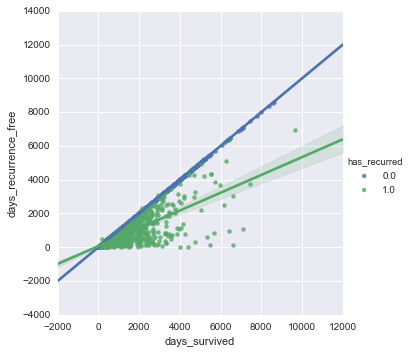

In [14]:
sns.lmplot('days_survived', 'days_recurrence_free', data=covariates_df, hue='has_recurred')
plt.show()

There is a modest correlation coefficient between <code>days_recurrence_free</code> and <code>days_survived</code>, conditioned on <code>recurred</code> being true:

In [15]:
days_corr_coef = covariates_df[covariates_df.has_recurred==1].corr().loc['days_survived']['days_recurrence_free']
print('Correlation coefficient: %.2f' % days_corr_coef)

Correlation coefficient: 0.76


This could be used to impute one given the other, and there is far more data on <code>days_survived</code>.

As shown in the <a href='https://github.com/cognoma/cancer-data/blob/master/3.explore-mutations.ipynb'>aforementioned notebook</a>, there is a correlation between <code>age_diagnosed</code> and <code>n_mutations_log1p</code> which could be used to impute age. Let's explore these on a disease-specific basic.

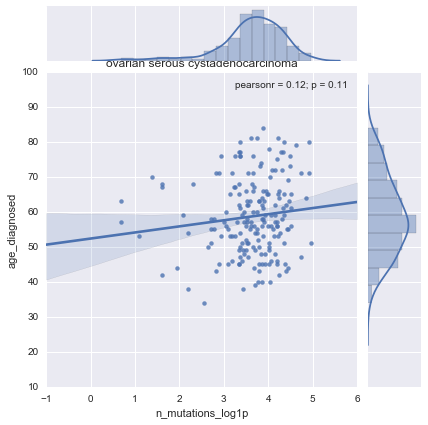

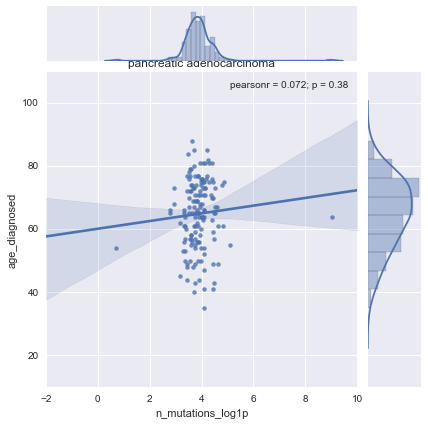

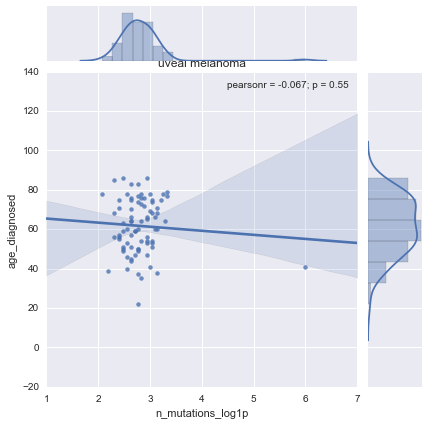

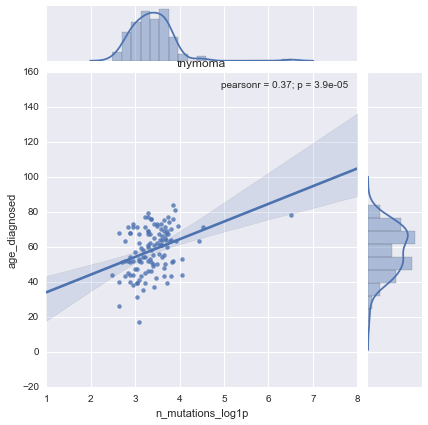

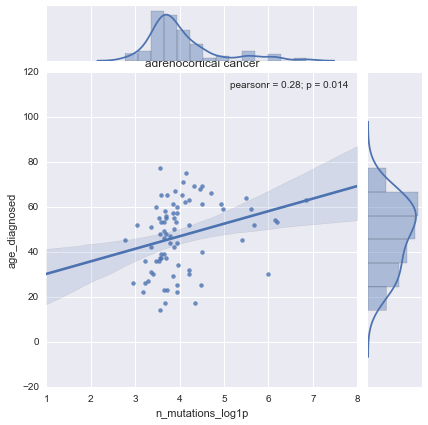

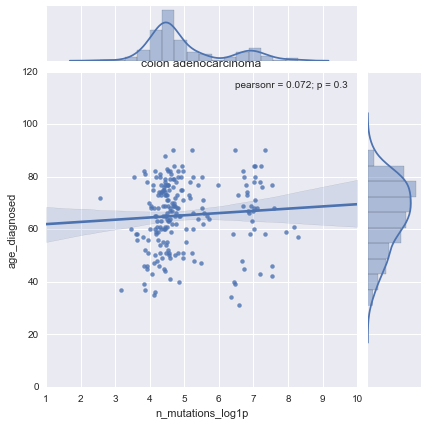

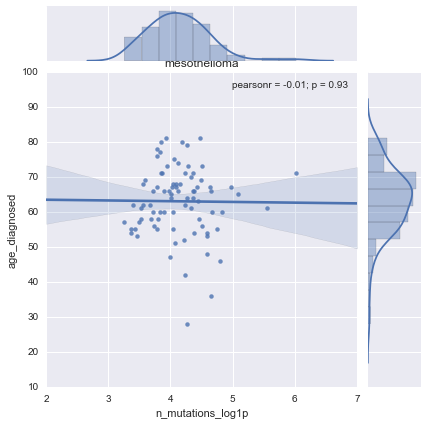

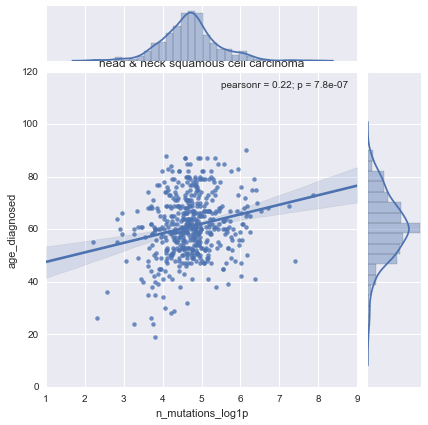

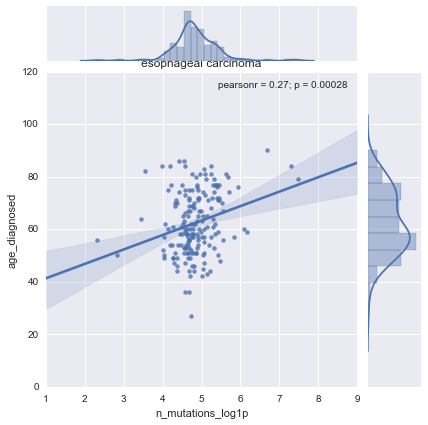

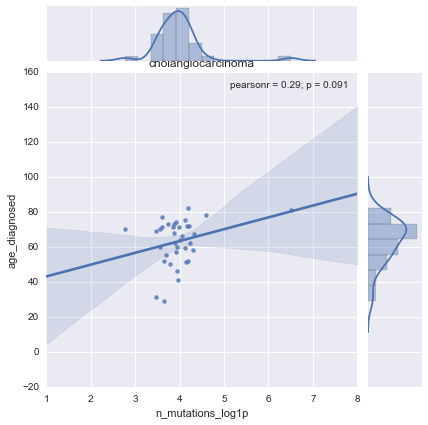

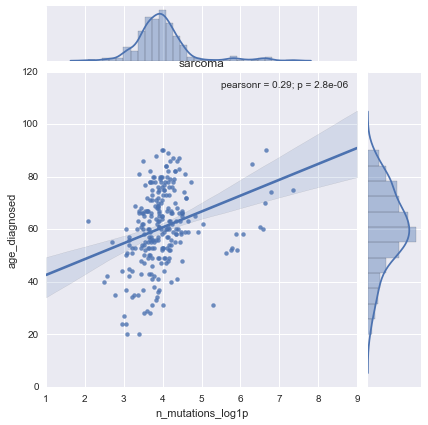

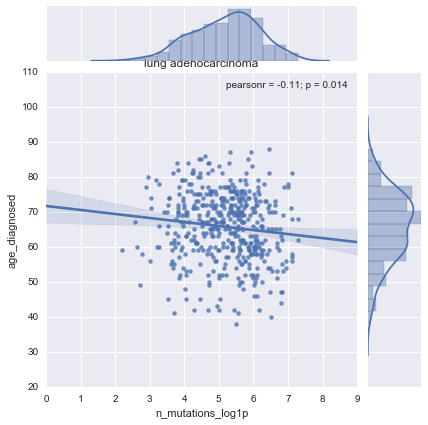

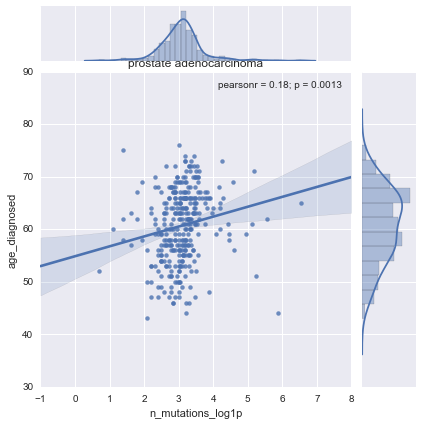

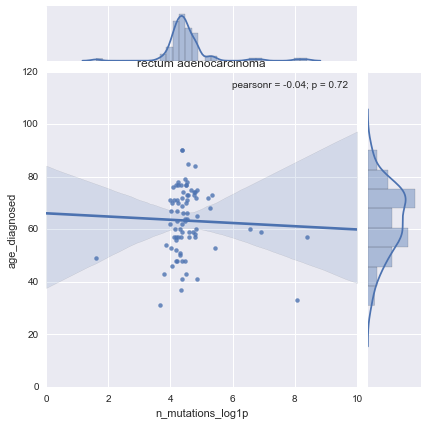

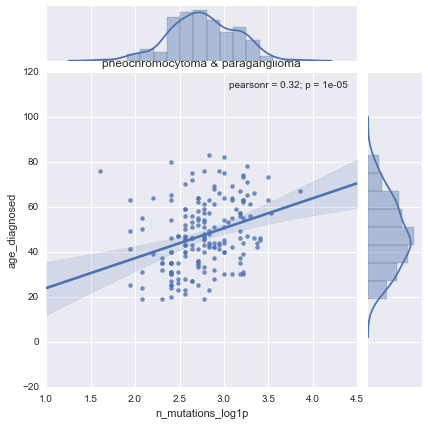

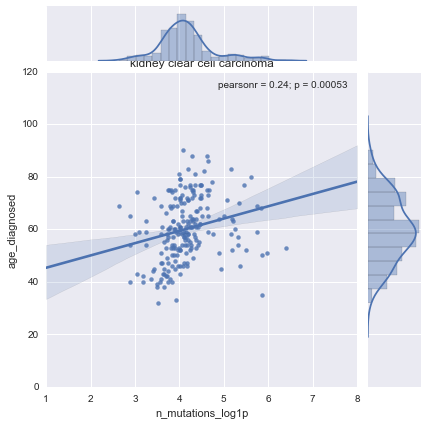

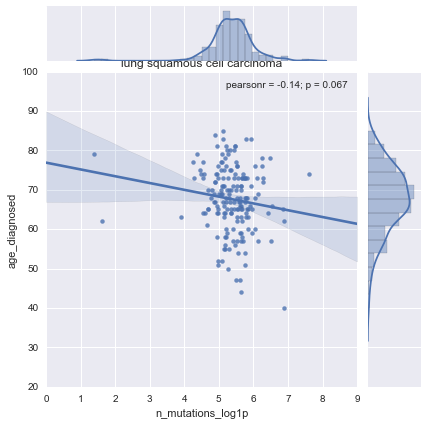

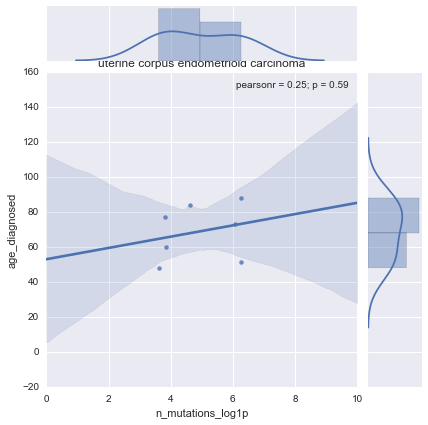

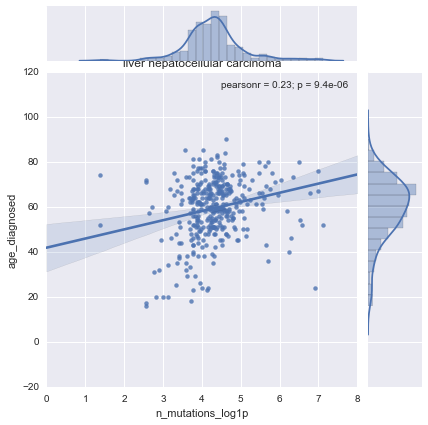

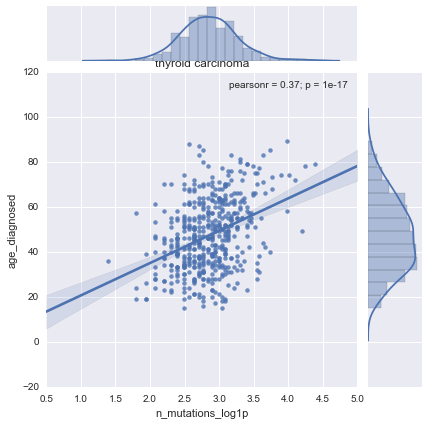

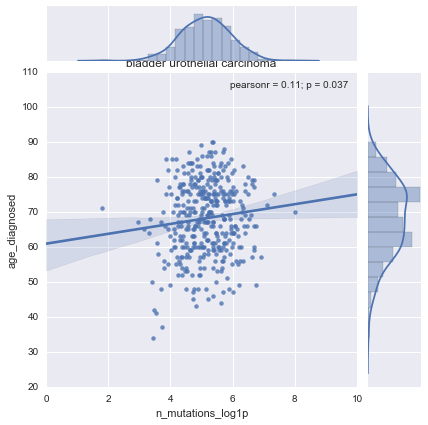

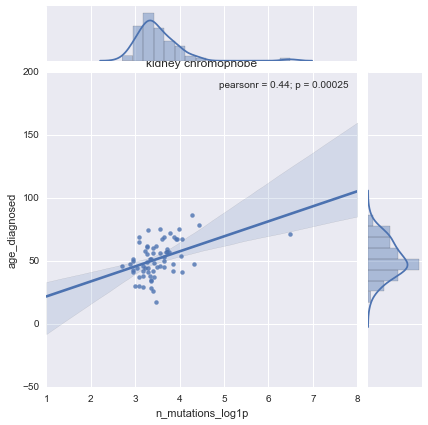

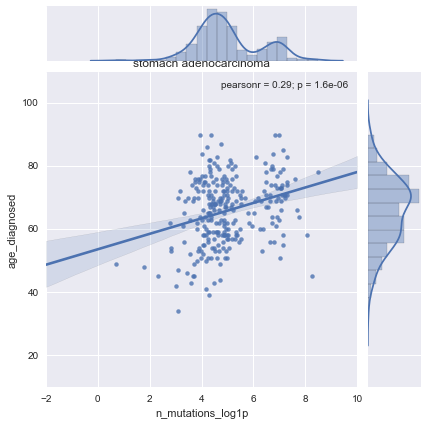

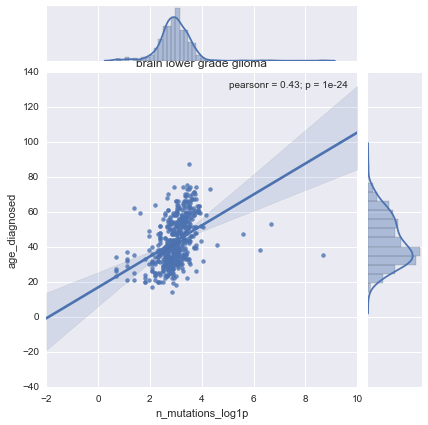

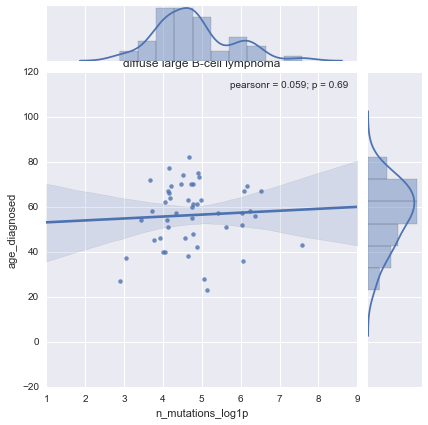

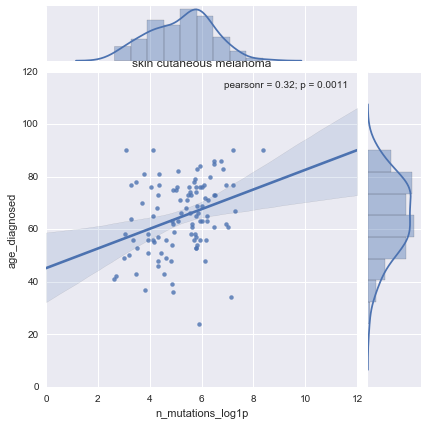

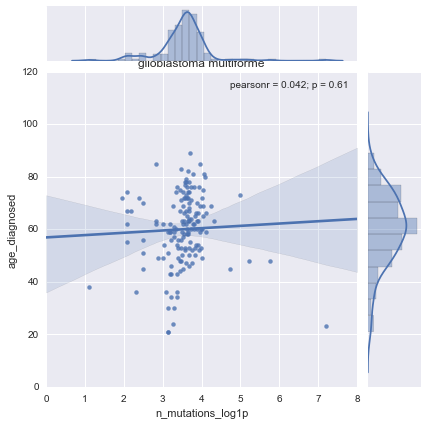

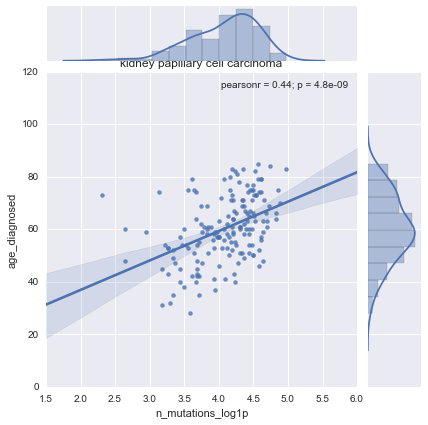

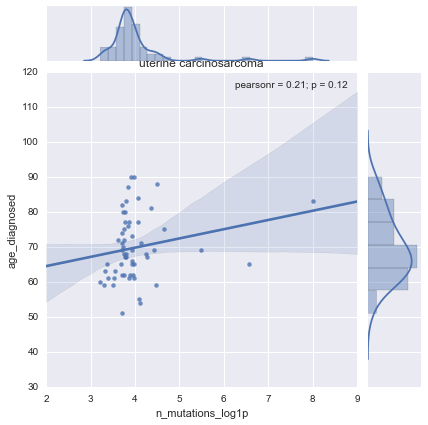

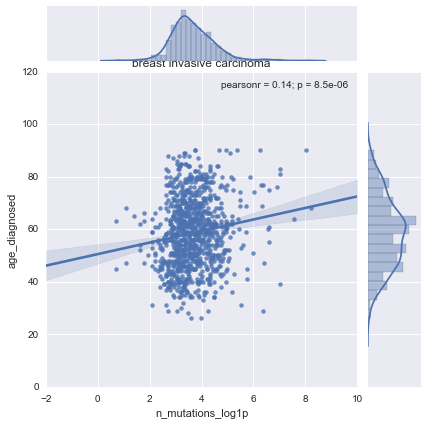

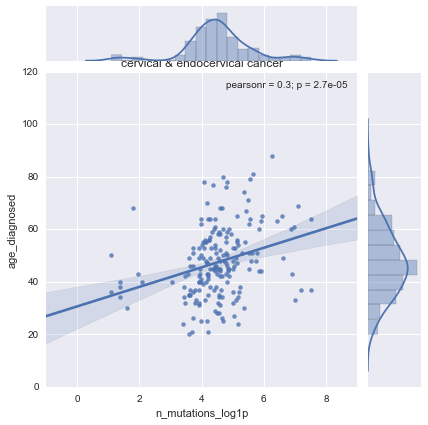

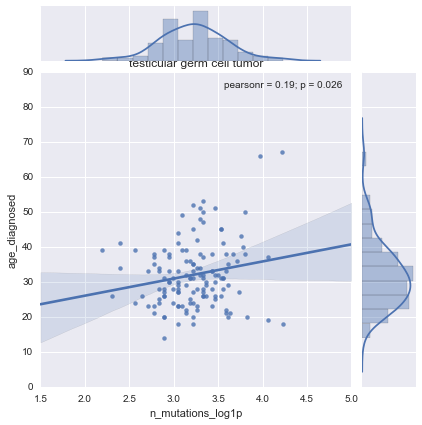

In [16]:
for disease in set(diseases):
    sns.jointplot('n_mutations_log1p',
                  'age_diagnosed',
                  covariates_df.loc[diseases==disease],
                  kind='reg')
    plt.title(disease)
    plt.show()

These seem to affected by outliers. Standard linear regression assumes errors are normally distributed, which have thin tails that can be disproportionately affected by outliers. It would be possible to do a Bayesian linear regression, replacing the normal with a thicker tailed Student-t. But perhaps there are simpler options. These issues will be explored in a future pull request.